In [2]:
import pandas as pd
import numpy as np
import glob
import os
import time
import matplotlib.pyplot as plt
import mplfinance as mpf

from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import *
from keras.regularizers import *
from keras.losses import *
from keras.utils import to_categorical
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import *
from sklearn.metrics import *
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
def getData(symbol):

    base_path = os.path.join(os.getcwd(), f"""data/INTRADAY_EXTENDED/5min/{symbol}""")

    #print(base_path)

    filenames = glob.glob(base_path + "/*.csv")

    dataframe_list = []

    for filename in filenames:

        dataframe_list.append(pd.read_csv(filename))

    # Concatenate all data into one DataFrame
    source_data = pd.concat(dataframe_list, ignore_index=True)

    source_data['timestamp'] = pd.to_datetime(source_data["time"])
    source_data['date'] = source_data['timestamp'].dt.date
    source_data['time'] = source_data['timestamp'].dt.time

    # sort ascending by time
    source_data.sort_values(by=['timestamp'], ascending=True, inplace=True)
    
    # Compute price difference in time step
    source_data['price_difference'] = source_data['close'] - source_data['open']

    # Price movement direction
#     source_data['price_movement_direction'] = source_data[['price_difference']].apply(lambda row: 0 if row['price_difference'] > 0 else 1, axis=1)

    # Filter on rows for time between 9:30 and 16:00

    return source_data[(source_data['time'] > datetime.strptime('09:00:00', '%H:%M:%S').time()) & (source_data['time'] <= datetime.strptime('16:00:00', '%H:%M:%S').time())].copy()

source_data = getData('GOOG')

source_data.head()

,time,open,high,low,close,volume,timestamp,date,price_difference
21470,09:15:00,1190.650,1190.65,1190.50,1190.500,888,2019-03-15 09:15:00,2019-03-15,-0.15
21469,09:30:00,1192.780,1193.19,1192.78,1192.970,1490,2019-03-15 09:30:00,2019-03-15,0.19
21468,09:35:00,1193.380,1193.38,1187.95,1188.030,427564,2019-03-15 09:35:00,2019-03-15,-5.35
21467,09:40:00,1188.315,1189.37,1187.24,1187.505,12415,2019-03-15 09:40:00,2019-03-15,-0.81
21466,09:45:00,1187.930,1190.30,1187.61,1190.300,11946,2019-03-15 09:45:00,2019-03-15,2.37


# Create features

In [4]:
def getPriceMovementDirection(data, span):
    
    data['close_shifted'] = data['close'].shift(-span)
    
    data['price_difference'] = data['close_shifted'] - data['open']
    
#     data['price_movement_direction'] = data['price_difference'].apply(lambda price_difference: 1 if price_difference > 0 else (0 if price_difference == 0 else -1))
    data['price_movement_direction'] = data['price_difference'].apply(lambda price_difference: 0 if price_difference > 0 else 1)

    return data['price_movement_direction']

    
def getEMA(values, span):
        
    data = pd.DataFrame.from_dict({'close': values})
    
    data['ema'] = data['close'].ewm(span=span, adjust=False).mean()
    
    return data['ema']


def getRSI(values, span):
    
    data = pd.DataFrame.from_dict({'close': values})

    data['delta'] = data['close'].diff()
    
    data['up'] = data['delta'].clip(upper=0)
    data['down'] = -1 * data['delta'].clip(lower=0)
    
    data['up_ema'] = data['up'].ewm(com=span, adjust=False).mean()
    data['down_ema'] = data['down'].ewm(com=span, adjust=False).mean()
    
    data['rs'] = data['up_ema']/data['down_ema']
    data['rsi'] = 100 - (100 / (1 + data['rs']))

    return data['rsi']

In [5]:
source_data['ema_12'] = getEMA(source_data['close'], 12)
source_data['ema_26'] = getEMA(source_data['close'], 26)
source_data['rsi_14'] = getRSI(source_data['close'], 14)

source_data = source_data.iloc[27:].copy()

source_data.head()

,time,open,high,low,close,volume,timestamp,date,price_difference,ema_12,ema_26,rsi_14
21443,11:40:00,1189.090,1189.6000,1188.48,1189.43,8428,2019-03-15 11:40:00,2019-03-15,0.340,1188.549223,1188.557069,32.425418
21442,11:45:00,1189.535,1190.0000,1188.88,1189.51,8955,2019-03-15 11:45:00,2019-03-15,-0.025,1188.697034,1188.627656,32.278553
21441,11:50:00,1189.670,1191.4300,1189.67,1191.30,23864,2019-03-15 11:50:00,2019-03-15,1.630,1189.097491,1188.825608,29.116968
21440,11:55:00,1191.290,1191.3200,1190.59,1191.08,7757,2019-03-15 11:55:00,2019-03-15,-0.210,1189.402492,1188.992600,30.019578
21439,12:00:00,1190.920,1192.0259,1190.92,1191.60,8391,2019-03-15 12:00:00,2019-03-15,0.680,1189.740570,1189.185740,29.081752


In [6]:
def labelEncodeY(values):
    
    encoder = LabelEncoder()

    encoder.fit(values)

    return encoder.transform(values)


def oneHotEncodeY(values):
    
    encoder = OneHotEncoder(handle_unknown='ignore')

    encoder.fit(values)

    return encoder.transform(values).toarray()

In [7]:
n_steps = 25
n_features = 1

X_columns = ['open', 'high', 'low', 'close', 'volume', 'price_difference', 'ema_12', 'ema_26', 'rsi_14']
X_intermediate = np.array(source_data[X_columns].values.tolist())
X = []

for index in range(0, X_intermediate.shape[0] - n_steps + 1, 1):
    
    X.append(np.transpose([MinMaxScaler().fit_transform(row.reshape(-1, 1)).flatten() for row in np.transpose(X_intermediate[index: index + n_steps])]))
    
X = np.array(X)

source_data['price_movement_direction'] = getPriceMovementDirection(source_data[['open', 'close']].copy(), n_steps)

price_movement_direction = source_data['price_movement_direction'].tolist()
y = oneHotEncodeY(np.array(price_movement_direction).reshape(-1, 1)[:-(n_steps-1)])

print(X.shape)
print(y.shape)

(39616, 25, 9)
(39616, 2)


In [8]:
def trainValidationTestSplit(X, y, validation_size=0.3, test_size=0.3):
    
    total_length = X.shape[0]
    
    max_validation_index = round(X.shape[0] * (1 - test_size))

    max_train_index = round(max_validation_index * (1 - test_size))
        
#     print(total_length)
#     print(max_train_index)
#     print(max_validation_index)
    
    return X[:max_train_index], X[max_train_index:max_validation_index], X[max_validation_index:], y[:max_train_index], y[max_train_index:max_validation_index], y[max_validation_index:]

X_train, X_validation, X_test, y_train, y_validation, y_test = trainValidationTestSplit(X, y, validation_size=0.3, test_size=0.30)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(19412, 25, 9)
(8319, 25, 9)
(11885, 25, 9)
(19412, 2)
(8319, 2)
(11885, 2)


# Create model

In [9]:
def createModel(timesteps, features, n_output):

    opt_adam = Adam(clipnorm=1.0, clipvalue=0.5, learning_rate=0.000001, beta_1=0.5, beta_2=0.9)
    
    opt_sgd = SGD(lr=0.001, clipvalue=0.5)

    # define model
    model = Sequential()
    model.add(LSTM(64, input_shape=(timesteps, features), kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=opt_sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = createModel(X_train.shape[1], X_train.shape[2], np.unique(y).shape[0])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 19,074
Trainable params: 19,074
Non-trainable params: 0
_________________________________________________________________


# Train and test

In [10]:
model = createModel(X_train.shape[1], X_train.shape[2], np.unique(y).shape[0])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, batch_size=32, verbose=2)


Train on 19412 samples, validate on 8319 samples
Epoch 1/40
 - 6s - loss: 7.9336 - accuracy: 0.4423 - val_loss: 7.0653 - val_accuracy: 0.5480
Epoch 2/40
 - 5s - loss: 6.3412 - accuracy: 0.5350 - val_loss: 5.6652 - val_accuracy: 0.5361
Epoch 3/40
 - 6s - loss: 5.1027 - accuracy: 0.5857 - val_loss: 4.5728 - val_accuracy: 0.5769
Epoch 4/40
 - 6s - loss: 4.1342 - accuracy: 0.6267 - val_loss: 3.7184 - val_accuracy: 0.6365
Epoch 5/40
 - 6s - loss: 3.3767 - accuracy: 0.6678 - val_loss: 3.0497 - val_accuracy: 0.6947
Epoch 6/40
 - 6s - loss: 2.7831 - accuracy: 0.7077 - val_loss: 2.5257 - val_accuracy: 0.7372
Epoch 7/40
 - 6s - loss: 2.3185 - accuracy: 0.7373 - val_loss: 2.1148 - val_accuracy: 0.7637
Epoch 8/40
 - 6s - loss: 1.9535 - accuracy: 0.7606 - val_loss: 1.7924 - val_accuracy: 0.7810
Epoch 9/40
 - 6s - loss: 1.6669 - accuracy: 0.7754 - val_loss: 1.5392 - val_accuracy: 0.7949
Epoch 10/40
 - 6s - loss: 1.4423 - accuracy: 0.7880 - val_loss: 1.3401 - val_accuracy: 0.8038
Epoch 11/40
 - 6s -

In [11]:
# test predict
y_predicted_confidence = model.predict(X_test, verbose=2)

y_predicted = np.argmax(y_predicted_confidence, axis=1)

In [12]:
np.max(np.max(y_predicted_confidence, axis=1))

0.85233605

In [13]:
print(np.unique(y_predicted, return_counts=True))
print(np.unique(np.argmax(y_test, axis=1), return_counts=True))

(array([0, 1]), array([6935, 4950]))
(array([0, 1]), array([6365, 5520]))


## Performance analysis

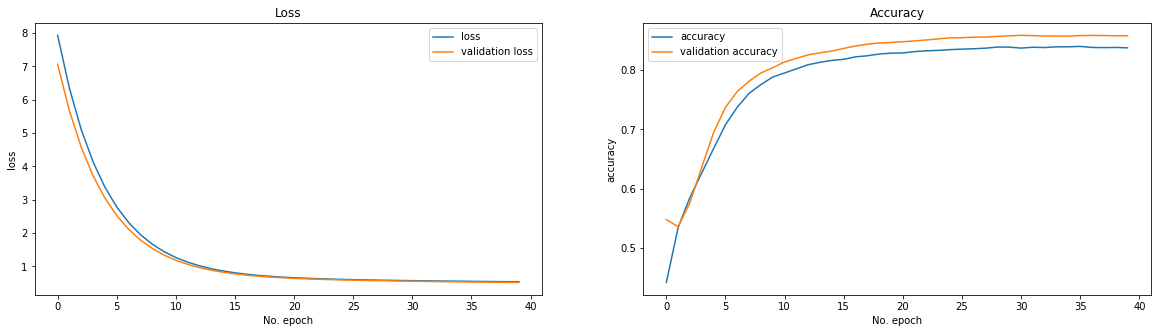

In [14]:
# Plot history: Loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].set_title('Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('No. epoch')
ax[0].legend()

# Plot history: Loss
ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
ax[1].set_title('Accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('No. epoch')
ax[1].legend()

plt.show()

In [15]:
print(classification_report(np.argmax(y_test, axis=1), y_predicted, target_names=['up', 'down']))


              precision    recall  f1-score   support

          up       0.82      0.90      0.86      6365
        down       0.87      0.78      0.82      5520

   micro avg       0.84      0.84      0.84     11885
   macro avg       0.85      0.84      0.84     11885
weighted avg       0.84      0.84      0.84     11885

